In [280]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pandas as pd

from datetime import datetime
import glob
from os.path import join

In [281]:
import sys
sys.path.append('../')
import config
from particles import coastal_particles, entering_particles

In [282]:
folder = '../data/output/'
start_date = datetime(2010, 1, 1)
name = 'cm_mpw_2010_01'
files = sorted(glob.glob(join(folder, f'{name}_*.nc')))

In [283]:
files[0]

'../data/output/cm_mpw_2010_01_001.nc'

In [284]:
files[-1]

'../data/output/cm_mpw_2010_01_071.nc'

In [285]:
nb_traj = xr.open_dataset(files[0]).dims['traj']
nb_obs = sum([xr.open_dataset(file).dims['obs'] for file in files]) - (len(files)-1)

In [286]:
# the particles are the combination of coastal-rivers
# and inputs from the boundary during all of start_date month
df_coasts_rivers = coastal_particles(config, start_date)
df_inputs = entering_particles(config, start_date)
df = pd.concat([df_coasts_rivers, df_inputs], ignore_index=True, axis=0)
df.to_csv(join(folder, f'{name}.csv'), index=False)
print(f"{len(df)} particles ({len(df_coasts_rivers)} at coast & rivers, {len(df_inputs)} at the boundaries) define for the monthly release ({start_date.year}-{start_date.month:02d}).")

11404 particles (11315 at coast & rivers, 89 at the boundaries) define for the monthly release (2010-01).


In [287]:
time = np.arange(0, nb_obs, dtype='int16')
lon = np.full((nb_traj, nb_obs), np.nan)
lat = np.full((nb_traj, nb_obs), np.nan)

In [289]:
offset = 0
for i, file in enumerate(files):
    df = xr.open_dataset(file)
    
    # get trajectory id
    j = df.trajectory[:,0].values.astype('int')
    if i == 0:
        k = slice(offset, offset+df.dims['obs'])
        lon[j, k] = df.lon
        lat[j, k] = df.lat 
    else:
        k = slice(offset, offset+df.dims['obs']-1)
        lon[j, k] = df.lon[:, 1:].values # initial position is repeated
        lat[j, k] = df.lat[:, 1:].values # initial position is repeated
    offset += df.dims['obs'] - 1
    df.close()

# create and save yearly netCDF 
xr.Dataset(
    data_vars=dict(
        # position and velocity
        lon=(['traj', 'obs'], lon, {'long_name': 'longitude', 'units':'degrees_east'}),
        lat=(['traj', 'obs'], lat, {'long_name': 'latitude', 'units':'degrees_north'}),
    ),

    coords=dict(
        time=(['obs'], time, {'long_name': 'time', 'units': f'days since {start_date.strftime("%Y-%m-%d:%H")}'}),
    ),

    attrs={
        'title': 'Caribbean Marine Litter trajectories',
        'description': f'Particles released during {start_date.strftime("%Y-%m")}.',
        'institution': 'Florida State University Center for Ocean-Atmospheric Prediction Studies (COAPS)',
        'date_created': datetime.now().isoformat(),
    }
).to_netcdf(join(folder, f'{name}.nc'))

In [25]:
df = xr.open_dataset(join(folder, f'{name}.nc'))
df

<xarray.Dataset>
Dimensions:  (traj: 11404, obs: 1212)
Coordinates:
    time     (obs) datetime64[ns] ...
Dimensions without coordinates: traj, obs
Data variables:
    lon      (traj, obs) float64 ...
    lat      (traj, obs) float64 ...
Attributes:
    title:         Caribbean Marine Litter trajectories
    description:   Particles released during 2010-01.
    institution:   Florida State University Center for Ocean-Atmospheric Pred...
    date_created:  2022-03-24T11:13:35.962433

In [26]:
df.close()

In [290]:
# simple function to fix the axis and make plot prettier
def geo_map(ax):
    # ticks
    ax.set_xticks([-90, -80, -70, -60], crs=ccrs.PlateCarree())
    ax.set_yticks([10, 20, 30], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # add land and coastline
    ax.add_feature(cfeature.LAND, facecolor='darkgrey', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    ax.set_extent([-98, -51, 3, 30])

In [291]:
df

<xarray.Dataset>
Dimensions:     (traj: 9310, obs: 31)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           spherical

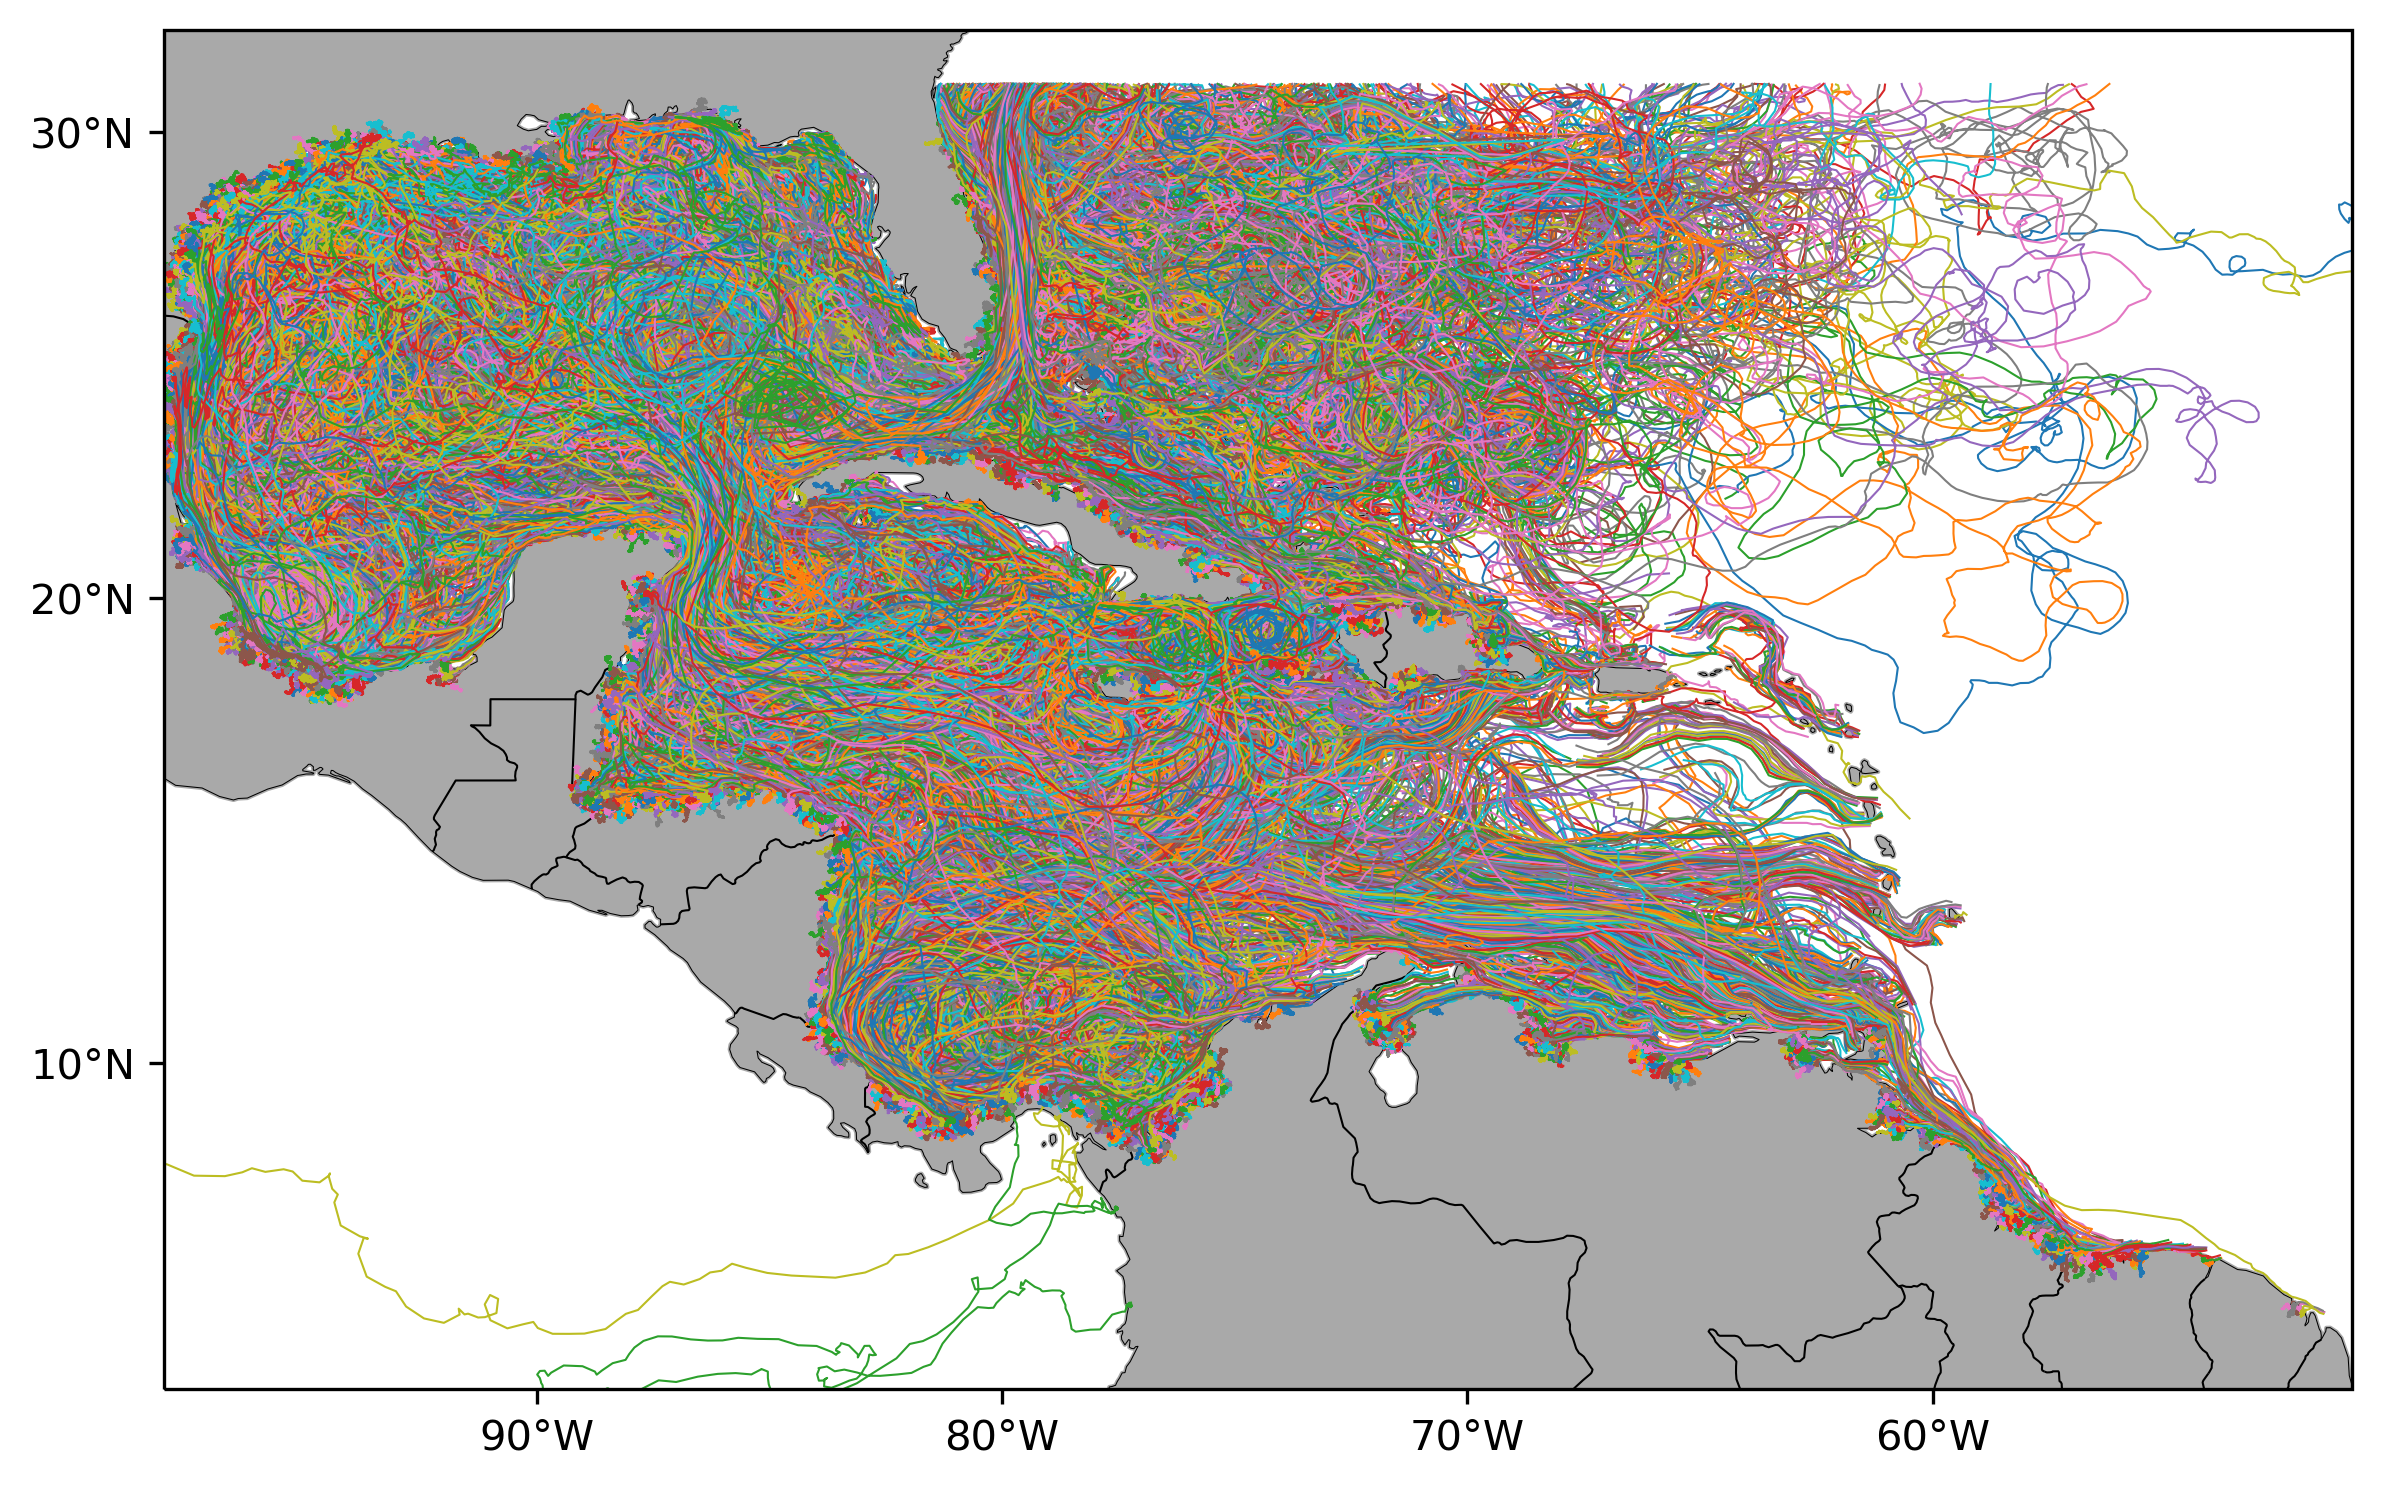

In [292]:
fig = plt.figure(figsize=(12,6), dpi=300)
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

ax.plot(lon.T, lat.T, linewidth=0.5);

geo_map(ax)

In [63]:
def particles_left(file):
    try:
        ds = xr.open_dataset(file)
        i = ds.dims['traj']
        p = np.sum(np.isfinite(ds.lon[:,-1].values))
        ds.close()
    except:
        i, p = 0, 0
    return i, p

In [64]:
particles_left('../data/output/cm_mpw_2010_01_001.nc')

(11404, 11154)

In [52]:
ds = xr.open_dataset('../data/output/cm_mpw_2010_01_001.nc')

In [70]:
np.sum(np.isfinite(ds.time[:, -1].values))

11154

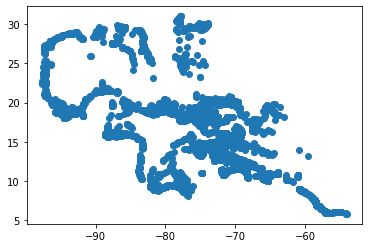

In [71]:
plt.scatter(ds.lon[:,-1], ds.lat[:,-1])